# はじめに

## このノートブックについて

このサンプルコードはTEIファイルを使って何らかのテキスト分析を行う際のヒントです。
まずは、どんな風にコードが動作するのか、各コードセルの実行ボタン（▶）を押して確認してください。

## このプロジェクトについて

大阪大学グローバル日本学教育研究拠点

2023年度 教育プログラム開発型

[拠点形成プロジェクト「人文科学分野向け研究データ管理を促進するデジタル・ヒューマニティーズ学習教材開発」](https://www.gjs.osaka-u.ac.jp/project/2023a/)

## ライセンスについて
ライセンスはクリエイティブコモンズライセンス[表示 4.0 国際 (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/deed.ja)です。ぜひ内容をアレンジして自分の目的を達成してください。



# 環境設定とデータの読み込み


まず、動作に必要なプログラムをインストールしましょう。
そして、コード左端にある実行ボタン(▶)をクリックしてください。

BeautifulSoupは、PythonでHTMLやXMLファイルを簡単に解析（パース）するためのライブラリ（まとまったプログラムのセット）です。Webスクレイピングやデータの抽出、文書の構造解析に便利です。

In [2]:
!pip install beautifulsoup4


次に、TEIデータを読み込みます。
TEI形式はXML形式でもあります。そのためファイルの拡張子はxmlです。このサンプルコードでは[青空文庫に格納されている、太宰治作「走れメロス」](https://www.aozora.gr.jp/cards/000035/files/1567_14913.html)のTEIデータを使います。




In [4]:
!curl -O 'https://raw.githubusercontent.com/nikolito/TEI-tools/main/meros.xml'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87937  100 87937    0     0   277k      0 --:--:-- --:--:-- --:--:--  277k


# TEI/XMLファイルの中身を見てみよう

ファイルから必要な情報を抽出するためには、まずは分析対象のTEI/XMLファイルの構造を調べる必要があります。

早速、さきほどダウンロードしたTEI/XMLファイルを読みだしてみましょう。

In [ ]:
from bs4 import BeautifulSoup

with open("meros.xml", encoding='utf8') as f:
    print(f.read())

<?xml version="1.0" encoding="UTF-8"?>
<TEI xmlns="http://www.tei-c.org/ns/1.0">
      <teiHeader>
            <fileDesc>
                  <titleStmt>
                        <title>走れメロス</title>
                        <author>太宰治</author>
                        <respStmt>
                              <resp>Transcription</resp>
                              <name>金川一之</name>
                        </respStmt>
                        <respStmt>
                              <resp>Proofreading</resp>
                              <name>高橋美奈子</name>
                        </respStmt>
                        <respStmt>
                              <resp>TEI encoding</resp>
                              <name>永崎研宣</name>
                        </respStmt>
                  </titleStmt>
                  <publicationStmt>
                        <distributor>青空文庫</distributor>
                        <authority>金川一之</authority>
                        <authority>高橋美奈子</authority>
   

## TEIファイルからタグを除去したテキストを表示しよう



In [10]:
#モジュールのインストール
from bs4 import BeautifulSoup

# TEIファイルを読み込んで、beautifulsoupがxml要素を取り出す
file_path = "meros.xml"

with open(file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "xml")

# <rt>タグを削除する
for ruby in soup.find_all("rt"):
    ruby.decompose()

# <text>要素を取り出して、その中のタグを除去（タグなしの本文テキストにする）
text_content = soup.find("text").get_text(strip=True)

# 最初の1000文字をタグなしテキストから表示する
print(text_content[:1000] + "...")

メロスは激怒した。必ず、かの邪智暴虐の王を除かなければならぬと決意した。メロスには政治がわからぬ。メロスは、村の牧人である。
                        笛を吹き、羊と遊んで暮して来た。けれども邪悪に対しては、人一倍に敏感であった。きょう未明メロスは村を出発し、野を越え山越え、十里はなれた此のシラクスの市にやって来た。メロスには父も、母も無い。女房も無い。 十六の、内気な妹と二人暮しだ。この妹は、村の或る律気な一牧人を、近々、花婿として迎える事になっていた。結婚式も間近かなのである。メロスは、それゆえ、花嫁の衣裳やら祝宴の御馳走やらを買いに、はるばる市にやって来たのだ。 先ず、その品々を買い集め、それから都の大路をぶらぶら歩いた。メロスには竹馬の友があった。セリヌンティウスである。今は此のシラクスの市で、石工をしている。
                        その友を、これから訪ねてみるつもりなのだ。久しく逢わなかったのだから、 訪ねて行くのが楽しみである。歩いているうちにメロスは、まちの様子を怪しく思った。 ひっそりしている。もう既に日も落ちて、まちの暗いのは当りまえだが、けれども、 なんだか、夜のせいばかりでは無く、市全体が、やけに寂しい。のんきなメロスも、 だんだん不安になって来た。路で逢った若い衆をつかまえて、何かあったのか、
                        二年まえに此の市に来たときは、夜でも皆が歌をうたって、まちは賑やかであった筈だが、と質問した。若い衆は、首を振って答えなかった。
                        しばらく歩いて老爺に逢い、
                        こんどはもっと、語勢を強くして質問した。老爺は答えなかった。メロスは両手で老爺のからだをゆすぶって質問を重ねた。老爺は、 あたりをはばかる低声で、わずか答えた。「王様は、人を殺します。」「なぜ殺すのだ。」「悪心を抱いている、というのですが、誰もそんな、悪心を持っては居りませぬ。」「たくさんの人を殺したのか。」「はい、はじめは王様の妹婿さまを。それから、御自身のお世嗣を。
                        それから、妹さまを。それから、妹さまの御子さまを。それから、皇后さまを。 それから、賢臣のア

改行がないので、少しレイアウトが崩れています。

textwrapライブラリを使ってもう少し読みやすく形を整えてみます。

In [9]:
# 20文字で折り返し、300字まで表示してみる
import textwrap

wrapped_text = textwrap.fill(text_content, width=20)
print(wrapped_text[:300] + "...")


メロスは激怒した。必ず、かの邪智暴虐の王
を除かなければならぬと決意した。メロスに
は政治がわからぬ。メロスは、村の牧人であ
る。
笛を吹き、羊と遊んで暮して来た。けれども
邪悪に対しては、人一倍に敏感であった。き
ょう未明メロスは村を出発し、野を越え山越
え、十里はなれた此のシラクスの市にやって
来た。メロスには父も、母も無い。女房も無
い。 十六の、内気な妹と二人暮しだ。この
妹は、村の或る律気な一牧人を、近々、花婿
として迎える事になっていた。結婚式も間近
かなのである。メロスは、それゆえ、花嫁の
衣裳やら祝宴の御馳走やらを買いに、はるば
る市にやって来たのだ。 先ず、その品々を
買い集...


ここから先では、XMLファイルのなかでご自身が必要とする情報のみを取り出す方法を見ていきます。そのためには、マークアップルールを確認することが極めて重要な作業ステップになります。

# このファイルのマークアップルールを確認するには

TEIファイルの中から必要な情報を出力する際には、どんなタグが使われているかと、その階層構造を調べる必要があります。

まずはタグの階層構造を簡単に把握できる便利なプログラムを紹介します。

In [5]:
from bs4 import BeautifulSoup
from IPython.display import display, HTML

def generate_collapsible_html(tag, indent=0):
    # 再起的にxmlタグを階層表示します
    children = tag.find_all(recursive=False)
    if not children:
        return f'<div style="margin-left: {indent}px;">{tag.name}</div>'

    inner_html = "".join([generate_collapsible_html(child, indent + 20) for child in children])
    return f"""
    <details style="margin-left: {indent}px;">
        <summary>{tag.name}</summary>
        {inner_html}
    </details>
    """

# XML要素をsoupに入れます
file_path = "meros.xml"
with open(file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "xml")

# HTML表示でタグの階層を開閉します
root = soup.find(True)  # 最初のタグを取得
html_output = generate_collapsible_html(root)
display(HTML(html_output))


↑上記セルを実行すると出力表示にTEIタグの階層構造が表示されます。 TEI > teiHeader > encodingDesc と順番に▶︎マークをクリックしていきましょう。
encodingDesc > editorialDecl > p > gi という階層になっていますね。

**XML形式のデータは必ず入れ子になっている**ので、プログラムで欲しいデータがある階層に辿り着くのが比較的簡単です。

# 人名や地名などをマークアップして名寄せしよう

特定の人名や地名を適切にマークアップすれば、表記が異なっていても機械的に抽出できます。有志がマークアップしたTEIファイルをインターネットからダウンロードできるので、テキストの特定の部分をマークアップする方法を学びましょう。



In [ ]:
#モジュールのインストール
from bs4 import BeautifulSoup
import textwrap

# TEIファイルを読み込んで、beautifulsoupがxml要素を取り出す
file_path = "meros.xml"
with open(file_path, "r", encoding="utf-8") as file:
  soup = BeautifulSoup(file, "xml")

# マークアップルールを記した<editorialDecl>を選択して、変数editoricalDeclに代入
editorialDecl = soup.select('editorialDecl')

# editorialDeclの中身を出力する
wrapped_text = textwrap.fill(editorialDecl[0].get_text(strip=True), width=50) # widthでお好みの幅に変えてください
print(wrapped_text.replace("  ", ""))


placeNameの@typeでは、実際にいた場所を"real"、そうでない場所を"unreal"と
して区別している。persNameは、人称代名詞以外の人や人々を指す名詞に付与している。人称代名詞に
はrsを付与している。いずれも@correspでID参照している。


## 上の出力結果の解説

\<editorialDecl>のなかには、以下のタグが入っています。このファイルでは、マークアップを行った人がplaceName、personName、rsタグを使って、名詞を場所、人名、人称代名詞の種類に分別しています。加えて、type属性でplaceNameにtype=realあるいはunrealを追加できるように定義しています。つまり、TEIマークアップを行った人が、**このファイルを使う全ての人に向けて**、editorialDeclタグの中で、それぞれのタグの持つ意味で名詞をテキストから抽出できるように定義を説明しています。

- \<p>（[散文における段落を示すタグ](https://www.tei-c.org/release/doc/tei-p5-doc/en/html/ref-p.html)）
- \<placeName>（[場所名](https://www.tei-c.org/release/doc/tei-p5-doc/en/html/ref-list.html)）
- \<personName>（[人名](https://www.tei-c.org/release/doc/tei-p5-doc/en/html/ref-item.html)）
- \<rs>（人称代名詞）

また、すべてのタグには**corresp**属性を付けて、名寄せを可能にしています。例えば、人称代名詞で「彼」と書かれているのがメロスであるならば、\<rs corresp="#メロス">彼</rs>とマークアップします。

- \#は同一文書内の要素を、テキスト内で参照できる**一意のID**で指定することを意味します。

- 参照先は、本文を表す\<text>タグ内ではなく、後付や参考文献、補足などを表記する**\<back>**タグの中に記載します。\<back>タグは、\<text>タグより後の同じ階層に置き、その中にIDのリストを以下の例の要領で記述していきます。

- 参照先の要素には**xml:id**属性を付与する必要があります。また、xml:idは文書内で一意でなければなりません。

```
（<text>内）
<persName corresp="#メロス">メロス</persName>
<placeName corresp="#シラクス">シラクス</placeName>

（<back>内）
<listPerson>
  <person xml:id="メロス">
    <persName>メロス</persName>
  </person>
</listPerson>
<listPlace>
  <place xml:id="シラクス">
    <placeName>シラクス</placeName>
  </place>
</listPlace>
```

## 名寄せをしよう

このTEIファイルでは、人名と地名の名寄せがすでに行われています。早速主人公のメロスが作中でどのような呼ばれ方をしているのかをリストにしてみましょう。そして、各呼び名の回数も表示してみましょう。

In [19]:
from bs4 import BeautifulSoup
from collections import Counter

# TEIファイルを読み込んで、BeautifulSoupで解析
file_path = "meros.xml"  # 実際のパスを指定
with open(file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "xml")

# <persName>タグのうちcorresp="#メロス"に該当する要素を抽出
melos_names = [pers.text for pers in soup.find_all("persName", {"corresp": "#メロス"})]

# 呼び名とその出現回数をカウント
name_counts = Counter(melos_names)

# 結果を表示
for name, count in name_counts.items():
  print(f"{name}: {count}回")


メロス: 68回

                        メロス: 6回

下賤
げせん
の者: 1回
嘘つき: 1回
兄: 4回
メロス ほどの男: 1回
おまえの兄: 1回
たぶん偉い男: 1回
真の勇者、メロス: 1回

                        自分: 1回
よくよく不幸な男: 1回
裏切者: 1回
地上で最も、不名誉の人種: 1回
悪徳者: 1回
醜い裏切り者: 1回
正義の士: 1回
正直な男: 2回
勇者: 1回


ちょっと、表示とカウントがおかしいですね。生のテキストにタグを付けていくので、表示がおかしくなることはよくあります。

余計なスペースと改行を名前から除去してカウントし直しましょう。

In [22]:
from bs4 import BeautifulSoup
from collections import Counter

# TEIファイルを読み込んで、BeautifulSoupで解析
file_path = "meros.xml"
with open(file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "xml")

# <persName>タグのうちcorresp="#メロス"に該当する要素を抽出
melos_names = []

for pers in soup.find_all("persName", {"corresp": "#メロス"}):
    # <rb>タグがある場合はその内容を抽出、ない場合は全体のテキストを使用
    if pers.find("rb"):
        melos_names.append(''.join(rb.text for rb in pers.find_all("rb")).strip())
    else:
        melos_names.append(pers.text.strip())

# 呼び名とその出現回数をカウント
name_counts = Counter(melos_names)

# 結果を表示
for name, count in name_counts.items():
    print(f"{name}: {count}回")


メロス: 74回
下賤: 1回
嘘つき: 1回
兄: 4回
メロス ほどの男: 1回
おまえの兄: 1回
たぶん偉い男: 1回
真の勇者、メロス: 1回
自分: 1回
よくよく不幸な男: 1回
裏切者: 1回
地上で最も、不名誉の人種: 1回
悪徳者: 1回
醜い裏切り者: 1回
正義の士: 1回
正直な男: 2回
勇者: 1回


上記の改良したコードで各呼び名の使用回数を正しくカウントしました。17種類の呼び名がありますが、すべてメロスのことを指しています。

名寄せすると、登場人物が周囲からどんな風に思われていたのかや、作中での変化を読み取れそうです。

## パラグラフごとにメロスの呼称を観察しよう

今度はパラグラフごとにメロスの呼ばれ方を見てみましょう。

In [34]:
from bs4 import BeautifulSoup
from collections import defaultdict
from IPython.display import display, Markdown

# TEIファイルを読み込んで、BeautifulSoupで解析
file_path = "meros.xml"  # 実際のパスを指定
with open(file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "xml")

# text > body > pタグについて、各<p>タグごとにメロスの呼び名を抽出する
paragraphs = soup.find("text").find("body").find_all("p")
melos_names_by_paragraph = defaultdict(list)

for i, p in enumerate(paragraphs, start=1):
    for pers in p.find_all("persName", {"corresp": "#メロス"}):
        if pers.find("rb"):
            name = ''.join(rb.text for rb in pers.find_all("rb")).strip()
        else:
            name = pers.text.strip()
        melos_names_by_paragraph[i].append(name)

# 結果を表示
for para_num, names in melos_names_by_paragraph.items():
    display(Markdown(f"### Paragraph {para_num}"))
    display(Markdown(", ".join(names) if names else "--"))


### Paragraph 1

メロス, メロス, メロス

### Paragraph 2

メロス, メロス, メロス

### Paragraph 3

メロス

### Paragraph 4

メロス, メロス, メロス, メロス

### Paragraph 5

メロス, メロス, メロス, メロス, メロス, メロス, 下賤, メロス, メロス, 嘘つき, メロス

### Paragraph 6

メロス, メロス, メロス

### Paragraph 7

メロス, メロス, 兄, 兄, 兄, メロス, メロス, メロス, メロス

### Paragraph 8

メロス, メロス, メロス, メロス ほどの男, おまえの兄, 兄, たぶん偉い男, メロス, メロス, メロス

### Paragraph 9

メロス, メロス

### Paragraph 10

メロス, メロス, メロス

### Paragraph 11

メロス, メロス, メロス, メロス, メロス, メロス

### Paragraph 12

メロス

### Paragraph 13

メロス, メロス, 真の勇者、メロス, 自分, よくよく不幸な男, 裏切者, 地上で最も、不名誉の人種, 悪徳者, 醜い裏切り者

### Paragraph 14

メロス, メロス, メロス, 正義の士, 正直な男, 正直な男

### Paragraph 15

メロス, メロス, メロス

### Paragraph 16

メロス, メロス, メロス, メロス, メロス, メロス, メロス

### Paragraph 17

メロス, メロス, メロス, メロス, メロス, メロス, メロス, メロス, メロス, メロス, メロス, メロス, 勇者

この物語の主要人物はメロス、ディオニス（王）、セリヌンティウス（メロスの親友）です。

今度は、メロス、ディオニス、セリヌンティウスの呼称をパラグラフごとに抽出して一覧表を作ってみましょう。

In [42]:
from bs4 import BeautifulSoup
from collections import defaultdict
import pandas as pd
from IPython.display import display

# TEIファイルを読み込んで、BeautifulSoupで解析
file_path = "meros.xml"  # 実際のパスを指定
with open(file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "xml")

# ターゲットとするキャラクター
characters = {
    "#メロス": "メロス",
    "#ディオニス": "ディオニス",
    "#セリヌンティウス": "セリヌンティウス"
}

# 各<p>タグごとにキャラクターの呼び名を抽出する
paragraphs = soup.find("text").find("body").find_all("p")
data = defaultdict(lambda: defaultdict(list))
paragraph_texts = {}

for i, p in enumerate(paragraphs, start=1):
    paragraph_texts[i] = p.get_text(strip=True)[:100]  # 各パラグラフの最初の100文字を取得
    for pers in p.find_all("persName"):
        corresp = pers.get("corresp")
        if corresp in characters:
            name = ''.join(rb.text for rb in pers.find_all("rb")).strip() if pers.find("rb") else pers.text.strip()
            data[i][characters[corresp]].append(name)

# DataFrameに変換し、各呼び名をカンマ区切りで表示
df = pd.DataFrame({char: ["、".join(data[para][char]) for para in range(1, len(paragraphs) + 1)] for char in characters.values()})
df.index = [f"P{i}" for i in range(1, len(paragraphs) + 1)]

# パラグラフのテキスト列を追加
df['Text (first 100 chars)'] = [paragraph_texts[para] for para in range(1, len(paragraphs) + 1)]

# 表を表示
display(df)


,メロス,ディオニス,セリヌンティウス,Text (first 100 chars)
P1,メロス、メロス、メロス,邪智暴虐,,メロスは激怒した。必ず、かの邪智暴虐じゃちぼうぎゃくの王を除かなければならぬと決意した。メロ...
P2,メロス、メロス、メロス,,,きょう未明メロスは村を出発し、野を越え山越え、十里はなれた此このシラクスの市にやって来た。メ...
P3,メロス,,竹馬の友、セリヌンティウス,メロスには竹馬の友があった。セリヌンティウスである。今は此のシラクスの市で、石工をしている。...
P4,メロス、メロス、メロス、メロス,王、王様、御自身、国王、王,,歩いているうちにメロスは、まちの様子を怪しく思った。 ひっそりしている。もう既に日も落ちて、...
P5,メロス、メロス、メロス、メロス、メロス、メロス、下賤、メロス、メロス、嘘つき、メロス,王、ディオニス、王、暴君、王、王、暴君、王、王、暴君、わし,セリヌンティウス、無二の友人、あの友人、身代りの男、身代りの男、身代り、その身代り,メロスは、 単純な男であった。買い物を、背負ったままで、 のそのそ王城にはいって行った。たち...
P6,メロス、メロス、メロス,暴君ディオニス,セリヌンティウス、友、セリヌンティウス、セリヌンティウス,竹馬の友、セリヌンティウスは、深夜、王城に召された。暴君ディオニスの面前で、佳よき友と佳き友...
P7,メロス、メロス、兄、兄、兄、メロス、メロス、メロス、メロス,,,メロスはその夜、一睡もせず十里の路を急ぎに急いで、村へ到着したのは、翌あくる日の午前、\n ...
P8,メロス、メロス、メロス、メロス ほどの男、おまえの兄、兄、たぶん偉い男、メロス、メロス、メロス,王,,結婚式は、真昼に行われた。新郎新婦の、\n 神...
P9,メロス、メロス,王,,眼が覚めたのは翌る日の薄明の頃である。メロスは跳ね起き、南無三、寝過したか、いや、まだまだ大...
P10,メロス、メロス、メロス,王,身代りの友,さて、メロスは、ぶるんと両腕を大きく振って、 雨中、矢の如く走り出た。私は、今宵、殺される。...


どの場面でどのような呼ばれ方をしているのか、変化がよりはっきりわかるのはメロスのようです。

次に、TEIならではの別のコードヒントを紹介します。

# 登場人物の共起ネットワーク分析

作品中で特定の人物がどの程度一緒に登場するかをパラグラフごとに分析してみましょう。

手順は以下の通りです。

1. 各パラグラフで登場するキャラクター（\<persName>）を抽出。
2. パラグラフ単位で共に登場するキャラクターidのペアを集計。
3. ネットワークグラフを作成し、共起頻度をエッジの太さで表現。

## 準備

最終的に人物ネットワーク図を生成します。
そのために必要なライブラリと日本語フォントを読み込みます。

（主要ライブラリ）
1. **networkx**: Pythonでグラフ（ネットワーク）構造を扱うための強力なライブラリです。ノード（点）とエッジ（線）で構成されるネットワークを作成、操作、分析、そして可視化するために設計されています。
2. **matplotlib**: Pythonでデータの可視化を行うための代表的なライブラリです。特に、2Dグラフの作成に優れており、シンプルな線グラフから複雑なヒートマップや3Dプロットまで、多様なグラフを描画できます。

### networkxの基本的な使い方

Nodes: ['A', 'B']
Edges: [('A', 'B', {'weight': 3})]


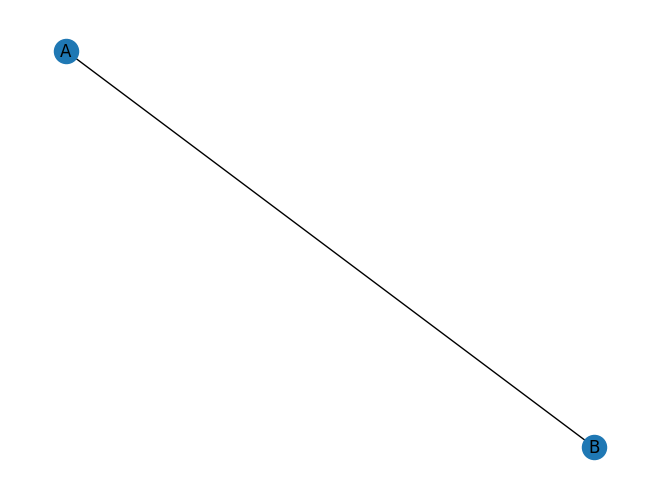

In [87]:
import networkx as nx
import matplotlib.pyplot as plt

# グラフの作成
G = nx.Graph()

# ノードの追加
G.add_node("A")
G.add_node("B")

# エッジの追加
G.add_edge("A", "B", weight=3)

# ノードとエッジの表示
print("Nodes:", G.nodes())
print("Edges:", G.edges(data=True))

# グラフの可視化
nx.draw(G, with_labels=True)
plt.show()

In [83]:
import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from collections import defaultdict
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches

# 日本語フォントの設定（Google Colabの場合には適切なフォントを利用）
# ColabではIPAexGothicなどが利用可能
! curl -O "https://raw.githubusercontent.com/notofonts/noto-cjk/main/Sans/OTF/Japanese/NotoSansCJKjp-Regular.otf"

font_path = 'NotoSansCJKjp-Regular.otf'  # Update with your font file path
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15.7M  100 15.7M    0     0  18.2M      0 --:--:-- --:--:-- --:--:-- 18.1M


## 各パラグラフで登場する人物を抽出

In [84]:
# TEIファイルを読み込んでBeautifulSoupで解析
file_path = "meros.xml"  # 実際のパスを指定
with open(file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "xml")

# listPersonから登場人物IDと名前を抽出
all_characters = {}
for person in soup.find_all("person"):
    person_id = person.get("xml:id")
    pers_name = person.find("persName")
    if person_id and pers_name:
        name = ''.join(rb.text for rb in pers_name.find_all("rb")).strip() if pers_name.find("rb") else pers_name.text.strip()
        all_characters[person_id] = name

print(all_characters)

{'メロス': 'メロス', 'ディオニス': 'ディオニス', 'セリヌンティウス': 'セリヌンティウス', 'メロスの妹': 'メロスの妹', 'メロスの妹の婿': 'メロスの妹の婿', 'ディオニスの妹婿': '妹婿さま', 'ディオニスの妹': '妹さま', 'ディオニスの妹の御子': '御子さま', 'ディオニスの世嗣': 'お世嗣', 'アレキス': 'アレキス', '老爺': '老爺', 'フィロストラトス': 'フィロストラトス'}


In [85]:
# パラグラフごとの共起データを収集
paragraphs = soup.find("text").find("body").find_all("p")
cooccurrence = defaultdict(list)

for para_num, p in enumerate(paragraphs, start=1):
    present_characters = set()

    for pers in p.find_all("persName"):
        corresp = pers.get("corresp")
        if corresp is not None:
            corresp = corresp.strip("#")
            if corresp in all_characters:
                present_characters.add(corresp)

    # 共起をパラグラフ別に記録
    for char1 in present_characters:
        for char2 in present_characters:
            if char1 != char2:
                cooccurrence[(char1, char2)].append(para_num)

print(cooccurrence)

defaultdict(<class 'list'>, {('メロス', 'ディオニス'): [1, 4, 5, 6, 8, 9, 10, 12, 13, 16, 17], ('ディオニス', 'メロス'): [1, 4, 5, 6, 8, 9, 10, 12, 13, 16, 17], ('メロスの妹の婿', 'メロス'): [2, 7, 8], ('メロスの妹の婿', 'メロスの妹'): [2, 7, 8], ('メロス', 'メロスの妹の婿'): [2, 7, 8], ('メロス', 'メロスの妹'): [2, 5, 7, 8], ('メロスの妹', 'メロスの妹の婿'): [2, 7, 8], ('メロスの妹', 'メロス'): [2, 5, 7, 8], ('セリヌンティウス', 'メロス'): [3, 5, 6, 10, 11, 13, 15, 16, 17], ('メロス', 'セリヌンティウス'): [3, 5, 6, 10, 11, 13, 15, 16, 17], ('ディオニスの妹婿', '老爺'): [4], ('ディオニスの妹婿', 'ディオニスの世嗣'): [4], ('ディオニスの妹婿', 'メロス'): [4], ('ディオニスの妹婿', 'ディオニス'): [4], ('ディオニスの妹婿', 'ディオニスの妹の御子'): [4], ('ディオニスの妹婿', 'アレキス'): [4], ('ディオニスの妹婿', 'ディオニスの妹'): [4], ('老爺', 'ディオニスの妹婿'): [4], ('老爺', 'ディオニスの世嗣'): [4], ('老爺', 'メロス'): [4], ('老爺', 'ディオニス'): [4], ('老爺', 'ディオニスの妹の御子'): [4], ('老爺', 'アレキス'): [4], ('老爺', 'ディオニスの妹'): [4], ('ディオニスの世嗣', 'ディオニスの妹婿'): [4], ('ディオニスの世嗣', '老爺'): [4], ('ディオニスの世嗣', 'メロス'): [4], ('ディオニスの世嗣', 'ディオニス'): [4], ('ディオニスの世嗣', 'ディオニスの妹の御子'): [4], ('ディオニスの世嗣', 'アレキス'): [4], ('ディオニスの世嗣', 'ディオ

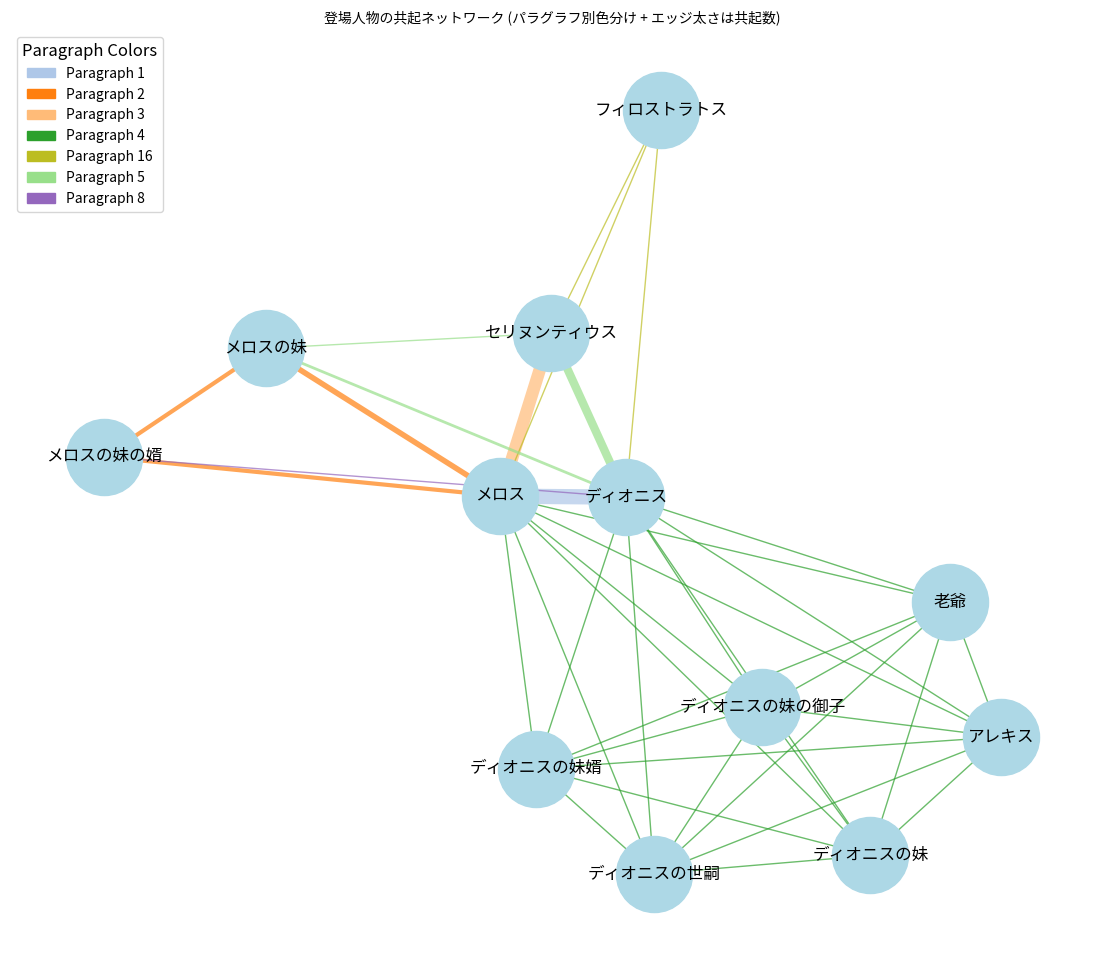

In [86]:
# ネットワークグラフの作成
G = nx.Graph()

for (char1, char2), paras in cooccurrence.items():
    G.add_edge(char1, char2, paragraphs=paras, weight=len(paras))  # エッジの太さは共起パラグラフ数に比例

# ノードラベルを対応する名前に変更
labels = {node: node for node in G.nodes}

# 色をパラグラフごとに割り当てる
colors = plt.cm.tab20.colors  # 20色のカラーマップ
edge_colors = []
color_map = {}

for _, _, data in G.edges(data=True):
    # パラグラフ番号で色を決定
    para_index = data['paragraphs'][0] % len(colors)
    edge_colors.append(colors[para_index])
    color_map[data['paragraphs'][0]] = colors[para_index]  # パラグラフ番号に対応する色を記録

# ノードの位置を決める
pos = nx.spring_layout(G, seed=42)

# ノードとエッジの描画
plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="lightblue")
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.7)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color="black", font_weight="bold", font_family=font_prop.get_name())

# 凡例を作成
legend_handles = [mpatches.Patch(color=color, label=f"Paragraph {para_num}") for para_num, color in color_map.items()]
plt.legend(handles=legend_handles, loc="upper left", title="Paragraph Colors", fontsize=10, title_fontsize=12, prop=font_prop)

# タイトル
plt.title("登場人物の共起ネットワーク (パラグラフ別色分け + エッジ太さは共起数)", fontsize=20, fontproperties=font_prop)
plt.axis('off')
plt.show()

## まとめ

### 図の構成と解釈

1. **ノード（青い円）**:
   - 各ノードは登場人物を表します。ノードラベルにはそれぞれの人物の名前が日本語で表示されています。
   - 例えば、「メロス」「ディオニス」「セリヌンティウス」といった登場人物が含まれています。

2. **エッジ（線）**:
   - エッジは、登場人物同士が同じパラグラフで共に登場したこと（共起）を表します。
   - **エッジの太さ**: 共起の頻度を示し、太いほど多くのパラグラフで一緒に登場していることを意味します。

3. **エッジの色**:
   - エッジの色は、どのパラグラフで共起が発生したかを示しています。
   - 各色は特定のパラグラフ番号に対応しており、凡例（legend）にその対応が表示されています。

4. **凡例（Legend）**:
   - パラグラフ番号ごとにエッジの色が割り当てられています。
   - 例えば、「Paragraph 1」が赤、「Paragraph 2」が青などのように、各パラグラフでの共起を色で簡単に識別できます。

---

### どのように読むか？
- **太くてカラフルなエッジ**:
  - 複数のパラグラフで共起が発生している登場人物のペア。重要な関係性を示している可能性があります。
  - 例: メロスとセリヌンティウスのエッジが太く、色が多ければ、物語の中で彼らが何度も共起していることを意味します。

- **細いエッジ**:
  - 一部のパラグラフでのみ共起が発生している登場人物のペア。関係が限定的であることを示します。

- **色の多さ**:
  - エッジに多くの色が使われている場合、登場人物同士が物語全体を通して頻繁に共起していることを示しています。

---

### この図で得られる洞察
- **主要な登場人物の関係**:
  - 太くカラフルなエッジは、物語の中で特に重要な関係性を示します。
  - 例: メロスとディオニス、メロスとセリヌンティウスなど。

- **パラグラフごとの特徴**:
  - 各パラグラフでどの登場人物が一緒に登場しているかを視覚的に把握できます。
  - 物語の展開に伴う人物関係の変化を追跡するのに役立ちます。

---

この図は物語の人物関係を視覚化する強力なツールです。より詳細な分析が必要な場合、各パラグラフの具体的な内容と照らし合わせて関係性を深掘りすることができます。